In [ ]:
#!cp /kaggle/input/data-bowl-2019-external-data/*.py /kaggle/working

In [1]:
%reload_ext autoreload
%autoreload 2
import warnings
import jupytools.syspath
def ignore(*args, **kwargs): pass
warnings.warn = ignore
jupytools.syspath.add('..')

In [44]:
import os
import re
from collections import defaultdict, Counter, OrderedDict
from functools import partial
from multiprocessing import cpu_count
from os.path import join

import feather
import joblib
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
from joblib import Parallel, delayed
from sklearn.model_selection import GroupKFold
from tqdm.auto import tqdm

import bundle
import utils as U
from dataset import load, load_sample, Subset, to_accuracy_group
from metric import qwk

## Extending The Dataset

The original datasets are processed as the whole to extend them with additional columns.

In [3]:
CYCLIC_FEATURES = ('Year', 'Month', 'Week', 'Dayofweek', 'Hour', 'Minute')

In [4]:
def add_feature_combinations(data, pairs):
    for c1, c2 in pairs:
        assert c1 in data.columns, f'Column not found: {c1}'
        assert c2 in data.columns, f'Column not found: {c2}'
        data[f'{c1}_{c2}'] = data[c1].astype(str).str.cat(data[c2].astype(str), '_')
    return data

def add_datetime(data, column, prefix=None, with_time=True):
    data[column] = pd.to_datetime(data[column])
    prefix = U.default(prefix, re.sub('[Dd]ate$', '', column))
    attrs = ('Year', 'Month', 'Week', 'Day', 'Dayofweek')
    if with_time:
        attrs += ('Hour', 'Minute')
    for attr in attrs:
        data[f'{prefix}_{attr}'] = getattr(data[column].dt, attr.lower())
    return data

def add_cyclical(data, prefix, features=CYCLIC_FEATURES, modulo=None):
    modulo = modulo or {}
    for feature in features:
        column = f'{prefix}_{feature}'
        m = modulo.get(feature, 23.0)
        data[f'{column}_sin'] = np.sin(2*np.pi*data[column] / m)
        data[f'{column}_cos'] = np.cos(2*np.pi*data[column] / m)
    return data

## Computing Meta Information

The meta-information is computed using public train and test datasets.

In [5]:
def compute_meta_data(dataset, *datasets):
    datasets = [dataset] + list(datasets)
    uniq = OrderedDict()
    uniq['title_event_code'] = U.unique(datasets, column='title_event_code')
    uniq['title'] = U.unique(datasets, column='title')
    uniq['event_code'] = U.unique(datasets, column='event_code')
    uniq['event_id'] = U.unique(datasets, column='event_id')
    uniq['world'] = U.unique(datasets, column='world')
    uniq['type'] = U.unique(datasets, column='type')
    asm_datasets = [ds.query('type == "Assessment"') for ds in datasets]
    uniq['assessment_titles'] = U.unique(asm_datasets, column='title')
    win_codes = {t: 4100 for t in uniq['title']}
    win_codes['Bird Measurer (Assessment)'] = 4110
    meta = {'win_codes': win_codes, **uniq}
    return U.named_tuple('Meta', **meta)

## User Features

Converts the raw dataset into user-specific features.

In [6]:
class FeaturesExtractor:
    def __init__(self, steps):
        self.steps = steps
        
    def init_steps(self, meta):
        for step in self.steps:
            if hasattr(step, 'init'):
                step.init(meta)
                
    def __call__(self, user, meta, test=False):
        rows = []
        self.init_steps(meta)
        for _, session in user.groupby('game_session', sort=False):
            info = session_info(session, meta, test)
            features = OrderedDict([
                ('installation_id', info.installation_id),
                ('game_session', info.game_session),
                ('session_title', info.session_title)
            ])
            for step in self.steps:
                extracted = step.extract(session, info, meta)
                features.update(extracted)
            if info.should_include:
                rows.append(features)
        return [rows[-1]] if test else rows
    
def session_info(session, meta, test):
    """Computes information about user's session."""
    assert not session.empty, 'Session cannot be empty!'
    session_type = session['type'].iloc[0]
    assessment = session_type == 'Assessment'
    outcomes = attempt_outcomes(session, meta) if assessment else None
    should_include = (
        (assessment and test) or
        (assessment and (len(session) > 1) and outcomes.total > 0))
    duration = session.timestamp.iloc[-1] - session.timestamp.iloc[0]
    return U.named_tuple(
        name='Info', 
        installation_id=session['installation_id'].iloc[0],
        game_session=session['game_session'].iloc[0],
        session_title=session['title'].iloc[0],
        session_type=session_type,
        is_assessment=assessment,
        should_include=should_include,
        outcomes=outcomes,
        duration_seconds=duration.seconds)

def attempt_outcomes(session, meta):
    """Computes how many successful and unsuccessful attempts contains the session."""
    event_code = meta.win_codes.get(session.title.iloc[0], 4100)
    total_attempts = session.query(f'event_code == {event_code}')
    pos = total_attempts.event_data.str.contains('true').sum()
    neg = total_attempts.event_data.str.contains('false').sum()
    summary = dict(pos=pos, neg=neg, total=(pos + neg))
    return U.named_tuple('Trial', **summary)

In [7]:
class BaseFeatures:
    def __init__(self, meta):
        self.init(meta)
        
class CountersMixin:
    def update_counters(self, cnt, sess, column):
        uniq_counts = Counter(sess[column])
        for k, v in uniq_counts.items():
            if k in cnt:
                cnt[k] += v

In [8]:
class CountingFeatures(BaseFeatures, CountersMixin):
    def init(self, meta):
        self.cnt_title_event_code = U.init_dict(meta.title_event_code)
        self.cnt_title = U.init_dict(meta.title)
        self.cnt_event_code = U.init_dict(meta.event_code)
        self.cnt_event_id = U.init_dict(meta.event_id)
        self.cnt_activities = U.init_dict(meta.type)
        self.last_activity = None
        
    def extract(self, session, info, meta):
        features = OrderedDict()
        if info.should_include:
            counters = OrderedDict([
                *self.cnt_title_event_code.items(),
                *self.cnt_title.items(),
                *self.cnt_event_code.items(),
                *self.cnt_event_id.items(),
                *self.cnt_activities.items()])
            features.update([(f'cnt_{k}', v) for k, v in counters.items()])
        self.update_counters(self.cnt_title_event_code, session, 'title_event_code')
        self.update_counters(self.cnt_title, session, 'title')
        self.update_counters(self.cnt_event_code, session, 'event_code')
        self.update_counters(self.cnt_event_id, session, 'event_id')
        if self.last_activity is None or self.last_activity != info.session_type:
            self.cnt_activities[info.session_type] += 1
            self.last_activity = info.session_type
        return features

In [9]:
class PerformanceFeatures(BaseFeatures):
    def init(self, meta):
        self.acc_accuracy = 0
        self.acc_accuracy_group = 0
        self.acc_correct_attempts = 0
        self.acc_incorrect_attempts = 0
        self.acc_actions = 0
        self.durations = []
        self.accuracy_groups = U.init_dict([0, 1, 2, 3])
        self.last_accuracy_title = U.init_dict([f'acc_{t}' for t in meta.title], -1)
        self.n_rows = 0
    
    def extract(self, session, info, meta):
        features = OrderedDict()
        
        if info.should_include:
            features['acc_attempts_pos'] = self.acc_correct_attempts
            features['acc_attempts_neg'] = self.acc_incorrect_attempts
            self.acc_correct_attempts += info.outcomes.pos
            self.acc_incorrect_attempts += info.outcomes.neg
            
            features['acc_accuracy'] = U.savediv(self.acc_accuracy, self.n_rows)
            accuracy = U.savediv(info.outcomes.pos, info.outcomes.total)
            self.acc_accuracy += accuracy
            
            features.update(self.last_accuracy_title)
            self.last_accuracy_title[f'acc_{info.session_title}'] = accuracy
            
            features['accuracy_group'] = to_accuracy_group(accuracy)
            self.accuracy_groups[features['accuracy_group']] += 1
            
            features['acc_accuracy_group'] = U.savediv(self.acc_accuracy_group, self.n_rows)
            self.acc_accuracy_group += features['accuracy_group']

            features['acc_actions'] = self.acc_actions
            
            features['duration_mean'] = np.mean(self.durations) if self.durations else 0
            self.durations.append(info.duration_seconds)
            
            self.n_rows += 1
            
        self.acc_actions += len(session)
        
        return features

In [10]:
class CyclicFeatures(BaseFeatures):
    def init(self, meta):
        self.acc = defaultdict(list)
    
    def extract(self, session, info, meta):
        features = OrderedDict()
        if not info.should_include:
            return features
        for dt in CYCLIC_FEATURES:
            for angle in ('sin', 'cos'):
                key = f'ts_{dt}_{angle}'
                acc = self.acc
                features[f'{key}_mean'] = np.mean(acc[key]) if acc[key] else 0
                features[f'{key}_std'] = np.std(acc[key]) if acc[key] else 0
                acc[key] += session[key].tolist()
        return features

In [11]:
class TimestampFeatures(BaseFeatures, CountersMixin):
    def init(self, meta):
        self.cnt_month = U.init_dict([7, 8, 9, 10])
        self.cnt_dayofweek = U.init_dict(range(7))
        self.cnt_dayofmonth = U.init_dict(range(1, 32))
        self.cnt_hour = U.init_dict(range(24))
        self.cnt_minute = U.init_dict(range(60))
        
    def extract(self, session, info, meta):
        features = OrderedDict()
        
        if info.should_include:           
            features.update(U.prefix_keys(self.cnt_month, 'month_'))
            features.update(U.prefix_keys(self.cnt_dayofweek, 'dow_'))
            features.update(U.prefix_keys(self.cnt_dayofmonth, 'dom_'))
            features.update(U.prefix_keys(self.cnt_hour, 'hour_'))
            features.update(U.prefix_keys(self.cnt_minute, 'minute_'))
        
        self.update_counters(self.cnt_month, session, 'ts_Month')
        self.update_counters(self.cnt_dayofweek, session, 'ts_Dayofweek')
        self.update_counters(self.cnt_dayofmonth, session, 'ts_Day')
        self.update_counters(self.cnt_hour, session, 'ts_Hour')
        self.update_counters(self.cnt_minute, session, 'ts_Minute')
        
        return U.prefix_keys(features, 'ts_')

In [12]:
class VarietyFeatures(BaseFeatures, CountersMixin):
    def init(self, meta):
        self.cnt_title_event_code = U.init_dict(meta.title_event_code)
        self.cnt_title = U.init_dict(meta.title)
        self.cnt_event_code = U.init_dict(meta.event_code)
        self.cnt_event_id = U.init_dict(meta.event_id)
        
    def extract(self, session, info, meta):
        features = OrderedDict()
        
        if info.should_include:
            for name in ('title_event_code', 'title', 'event_code', 'event_id'):
                cnt = getattr(self, f'cnt_{name}')
                nonzeros = np.count_nonzero(list(cnt.values()))
                features[name] = nonzeros

        self.update_counters(self.cnt_title_event_code, session, 'title_event_code')
        self.update_counters(self.cnt_title, session, 'title')
        self.update_counters(self.cnt_event_code, session, 'event_code')
        self.update_counters(self.cnt_event_id, session, 'event_id')
        
        return U.prefix_keys(features, 'var_')

## Preparing Dataset In Memory
There are two possible algorithms to prepare the data before training:
1. store every user subset on disk and process it from there,
2. keep the whole dataset in memory and process without dumping on disk (local training).

The first approach is more difficult, and requires extra steps between pipeline stages. Therefore, we go with the second one and hope that the data fits into memory on kernel.

In [13]:
class InMemoryAlgorithm:
    def __init__(self, extractor, meta, pbar=True, num_workers=cpu_count()):
        self.extractor = extractor
        self.meta = meta
        self.pbar = pbar
        self.num_workers = num_workers
    
    def run(self, dataset, test=False):
        mode = 'test' if test else 'train'
        U.log(f'Running algorithm in {mode} mode.')
        
        def _extract(user):
            return pd.DataFrame(self.extractor(user, self.meta, test))
        
        grouped = dataset.groupby('installation_id', sort=False)
        users = (g for _, g in grouped)
        if self.pbar:
            users = tqdm(users, total= grouped.ngroups)
        datasets = U.parallel(_extract, users, num_workers=self.num_workers)
        dataset = pd.concat(datasets, axis=0)
        return dataset

In [14]:
def encode(dataset, columns, encoders=None):
    def make_encoder(mapping):
        return lambda x: mapping.get(x, -1)
    encoders = encoders or {}
    for column in columns:
        if column in encoders:
            dataset[column] = dataset[column].map(make_encoder(encoders[column]))
        else:
            encoded, labels = pd.factorize(dataset[column])
            encoder = OrderedDict([(x, i) for i, x in enumerate(labels)])
            encoders[column] = encoder
            dataset[column] = encoded
    return dataset, encoders

## Post-processing Features
Some features can be added only when user-wise features are created and represented as data frame. This features are created in this section.

In [15]:
def add_user_wise_features(dataset, meta, pbar=True):
    def transform(group_obj, key, agg): 
        return group_obj[key].transform(agg)
    
    events = [f'cnt_{code}' for code in meta.event_code]
    grouped = dataset.groupby('installation_id')
    dataset['user_session_cnt'] = transform(grouped, 'cnt_Clip', 'count')
    dataset['user_duration_mean'] = transform(grouped, 'duration_mean', 'mean')
    dataset['user_title_nunique'] = transform(grouped, 'session_title', 'nunique')
    dataset['user_events_sum'] = dataset[events].sum(axis=1)
    dataset['user_events_mean'] = transform(grouped, 'user_events_sum', 'mean')

## Getting Relevant Features Only

In [16]:
class FeatureSelection:
    def __init__(self, rules, ignore_cols=None):
        self.rules = rules
        self.ignore_cols = ignore_cols or []
        self.selected = None
    def select(self, dataset):
        relevant = {}
        total = len(dataset.columns)
        if self.ignore_cols:
            U.log(f'Excluding from consideration: {self.ignore_cols}')
            dataset = dataset.drop(columns=self.ignore_cols)
        for name, rule in self.rules:
            U.log(f'Applying feature selection rule: {name}')
            features = rule(dataset)
            relevant[name] = set(features)
            U.log(f'Selected features: {len(features)} of {total}')
        U.log(f'Keeping only features, selected by every rule.')
        features = set.intersection(*relevant.values())
        U.log(f'Final number of features changed from {total} to {len(features)}')
        return sorted(list(features))
        
def non_zero_rows_and_cols(dataset):
    def nonzero(x): return not np.allclose(x, 0)
    nonzero_rows = dataset.sum(axis=1).map(nonzero)
    nonzero_cols = dataset.sum(axis=0).map(nonzero)
    features = dataset.loc[nonzero_rows, nonzero_cols].columns.tolist()
    return features

def non_correlated_cols(dataset, threshold=0.995):
    from itertools import combinations
    correlated = set()
    columns = dataset.columns
    pairs = combinations(columns, 2)
    n_pairs = len(columns)*(len(columns) - 1)//2
    for a, b in tqdm(pairs, total=n_pairs):
        if a in correlated: continue
        if b in correlated: continue
        c = np.corrcoef(dataset[a], dataset[b])[0][1]
        if c > threshold:
            correlated.add(b)
    return [c for c in columns if c not in correlated]

## Raw Into Prepared Pipeline
Gathering all created functions into data preparing pipeline.

In [17]:
sample = False
if U.on_kaggle():
    U.log('Loading test set only.')
    tst_data = pd.read_csv('/kaggle/input/data-science-bowl-2019/test.csv')
else:
    if sample:
        U.log('Warning: loading train and test data sample.')
        trn_data, _, _ = load_sample(Subset.Train, 500_000)
        [tst_data] = load_sample(Subset.Test, 500_000)
    else:
        U.log('Loading train and test.')
        trn_data, trn_spec, trn_targ = load(Subset.Train)
        [tst_data] = load(Subset.Test)

Loading train and test.
(11341042, 11) (17690, 7) (386, 3) (1156414, 11) 

In [18]:
transform = U.combine(
    partial(add_feature_combinations, pairs=[('title', 'event_code')]),
    partial(add_datetime, column='timestamp', prefix='ts'),
    partial(add_cyclical, prefix='ts'))

if U.on_kaggle():
    U.log('Transforming test data only.')
    X_tst = transform(tst_data.copy())
    U.log(X_tst.shape)
else:
    U.log('Transforming train and test data.')
    X_tst = transform(tst_data.copy())
    X_trn = transform(trn_data.copy())
    U.log(X_trn.shape, X_tst.shape)

Transforming train and test data.
(11341042, 31) (1156414, 31)


In [19]:
if U.on_kaggle():
    U.log('Reading pre-computed meta from disk.')
    meta = bundle.meta()
else:
    U.log('Computing meta using train and test datasets.')
    meta = compute_meta_data(X_trn, X_tst)
    U.log('Saving computed meta on disk.')
    bundle.save_meta(meta, 'meta')

Computing meta using train and test datasets.
Saving computed meta on disk.


In [20]:
extractor = FeaturesExtractor([
    CountingFeatures(meta),
    PerformanceFeatures(meta),
    CyclicFeatures(meta),
    TimestampFeatures(meta),
    VarietyFeatures(meta)
])
algo = InMemoryAlgorithm(extractor, meta, num_workers=12)
cat_cols = ['session_title']

In [21]:
if U.on_kaggle():
    U.log('Preparing test dataset.')
    X_tst = algo.run(X_tst, test=True)
    encoders = bundle.encoders()
    X_tst, _ = encode(X_tst, cat_cols, encoders=encoders)
else:
    U.log('Preparing train and test datasets.')
    X_trn = algo.run(X_trn)
    X_tst = algo.run(X_tst, test=True)
    X_trn, encoders = encode(X_trn, cat_cols)
    X_tst, _ = encode(X_tst, cat_cols, encoders=encoders)
    bundle.save(encoders, 'encoders')

Preparing train and test datasets.
Running algorithm in train mode.



Running algorithm in test mode.


In [22]:
if U.on_kaggle():
    U.log('Running post-processing on test set only.')
    add_user_wise_features(X_tst, meta)
else:
    U.log('Running post-processing on train and test sets.')
    add_user_wise_features(X_trn, meta)
    add_user_wise_features(X_tst, meta)

Running post-processing on train and test sets.


In [23]:
selector = FeatureSelection(
    rules=[
        ('nonzero', non_zero_rows_and_cols),
        ('uncorr', non_correlated_cols),
    ],
    ignore_cols=[
        'accuracy_group', 
        'installation_id', 
        'game_session'
    ]
)

if U.on_kaggle():
    U.log('Loading relevant features list from disk.')
    features = bundle.features()
else:
    U.log('Deriving relevant features from train dataset.')
    features = selector.select(X_trn)
    bundle.save(features, 'features')

Deriving relevant features from train dataset.
Excluding from consideration: ['accuracy_group', 'installation_id', 'game_session']
Applying feature selection rule: nonzero
Selected features: 1073 of 1090
Applying feature selection rule: uncorr


/home/ck/anaconda3/envs/fastai_10/lib/python3.7/site-packages/numpy/lib/function_base.py:2530: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/ck/anaconda3/envs/fastai_10/lib/python3.7/site-packages/numpy/lib/function_base.py:2531: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]



Selected features: 580 of 1090
Keeping only features, selected by every rule.
Final number of features changed from 1090 to 566


## Modelling

In [24]:
class LightGBM:
    def __init__(self, config):
        self.model = lgb.LGBMRegressor(**config.get('model_params', {}))
        self.config = config
        self.features = None
    def fit(self, train_data, valid_data, metric):
        x_trn, y_trn = train_data
        x_val, y_val = valid_data
        params = self.config.get('fit_params', {}).copy()
        params['eval_set'] = [(x_trn, y_trn), (x_val, y_val)]
        params['eval_names'] = ['trn', 'val']
        params['eval_metric'] = metric
        params['X'] = x_trn
        params['y'] = y_trn
        self.features = x_trn.columns.tolist()
        self.model.fit(**params)
    def predict(self, X):
        if self.features is not None:
            assert list(X.columns) == self.features, 'Features do not match!'
        return self.model.predict(X)
    @property
    def feature_importances(self):
        feat_imp = pd.Series(OrderedDict(
            zip(self.features, self.model.feature_importances_)))
        feat_imp.sort_values(inplace=True, ascending=False)
        return feat_imp
                  
def plot_feat_imp(ser, ax=None, **fig_kwargs):
    if ax is None:
        _, ax = plt.subplots(1, 1, **fig_kwargs)
    ser.plot.barh(ax=ax)
    return ax
    
MODEL_CONFIG = dict(
    lightgbm=dict(
        model_params=dict(
            n_estimators=5000,
            max_depth=15,
            boosting_type='gbdt',
            metric='rmse',
            objective='regression',
            learning_rate=1e-2,
            subsample=0.75,
            subsample_freq=1,
            feature_fraction=0.9,
            lambda_l1=1,
            lambda_l2=1
        ),
        fit_params=dict(
            early_stopping_rounds=100,
            verbose=100,
            categorical_feature='auto'
        )
    )
)

def get_default_config(name):
    return MODEL_CONFIG[name]

def get_model_class(name):
    if name == 'lightgbm': return LightGBM
    raise ValueError(f'unknown model class: {name}')

In [25]:
def inference(data, features, bounds, model='lightgbm', version='003', chunk_size=128):
    U.log(f'Running inference on dataset of shape: {len(features)}')
    indexes = np.arange(len(data))
    U.log(f'Loading external models: {model} v{version}.')
    models = bundle.models(model=model, version=version)
    preds = {i: [] for i, _ in enumerate(models)}
    U.log('Running models on test data...')
    for chunk in U.chunks(indexes, chunk_size):
        x_test = data[features].iloc[chunk]
        for i, model in enumerate(models):
            pred = model.predict(x_test).tolist()
            preds[i].extend(pred)
    U.log('Averaging ensemble predictions.')
    avg_preds = pd.DataFrame(preds).mean(axis=1).values
    U.log('Rounding predictions using optimal bounds.')
    y_hat = round_regressor_predictions(avg_preds, bounds)
    return y_hat

In [26]:
def submit(predicted, filename='submission.csv'):
    U.log('Converting predictions into submission file.')
    if U.on_kaggle():
        U.log('Running on Kaggle.')
        sample = pd.read_csv('/kaggle/input/data-science-bowl-2019/sample_submission.csv')
    else:
        U.log('Running locally.')
        [sample] = load(Subset.Sample)
    sample['accuracy_group'] = predicted.astype(int)
    sample.to_csv(filename, index=False)
    return filename

In [27]:
def train(dataset, features, reg_metric, algo='lightgbm', n_folds=5, config=None):
    models = []
    folds = GroupKFold(n_splits=n_folds)
    groups = dataset['installation_id']
    X = dataset[features].copy()
    y = dataset['accuracy_group']
    oof = np.zeros(X.shape[0], dtype=np.float32)
    cv = OrderedDict()
    model_cls = get_model_class(algo)
    metric = getattr(reg_metric, algo)
    feat_imp = np.zeros(len(features), dtype=np.float32)
    
    for i, (trn_idx, val_idx) in enumerate(folds.split(X, y, groups), 1):
        U.log(f'Running k-fold {i} of {n_folds}')
        x_trn, y_trn = X.iloc[trn_idx], y.iloc[trn_idx]
        x_val, y_val = X.iloc[val_idx], y.iloc[val_idx]
        model = model_cls(config or get_default_config(algo))
        model.fit(train_data=(x_trn, y_trn), 
                  valid_data=(x_val, y_val), 
                  metric=metric)
        oof[val_idx] = model.predict(x_val)
        cv[f'cv_cappa_{i}'] = np.mean(reg_metric(y_val, oof[val_idx]))
        models.append(model)
        feat_imp += model.feature_importances.values
    
    feat_imp /= n_folds
    feat_imp = pd.Series(OrderedDict(zip(features, feat_imp)))
    return U.named_tuple('Result', models=models, cv=cv, oof=oof, fi=feat_imp)

In [28]:
class RegressionCappa:
    def __init__(self, bounds):
        self.bounds = bounds
    def __call__(self, y_true, y_pred):
        y_rounded = round_regressor_predictions(y_pred, self.bounds)
        metric = qwk(y_true, y_rounded)
        return metric
    def lightgbm(self, y_true, y_pred):
        return 'cappa', self(y_true, y_pred), True
    
def round_regressor_predictions(preds, coefs):
    x = preds.copy()
    for i, (lo, hi) in enumerate(zip(coefs[:-1], coefs[1:])):
        x[(x > lo) & (x <= hi)] = i
    return x

def optimize_rounding_bounds(X, y):
    def _loss(coef):
        buckets = pd.cut(X, [-np.inf] + list(np.sort(coef)) + [np.inf], labels=[0, 1, 2, 3])
        return -qwk(y, buckets)
    
    init_coef = [0.5, 1.5, 2.5]
    opt_coef = scipy.optimize.minimize(_loss, init_coef, method='nelder-mead')
    optimized = opt_coef['x']
    return [-np.inf] + optimized.tolist() + [np.inf]

In [29]:
U.log('Training with sub-optimal rounding.')
reg_metric = RegressionCappa([-np.inf, 1., 2., 3., +np.inf])
result = train(X_trn, features, reg_metric, algo='lightgbm', n_folds=3)

Training with sub-optimal rounding.
Running k-fold 1 of 3
Training until validation scores don't improve for 100 rounds.
[100]	trn's rmse: 1.02964	trn's cappa: 0.37336	val's rmse: 1.06824	val's cappa: 0.339512
[200]	trn's rmse: 0.957235	trn's cappa: 0.4947	val's rmse: 1.01798	val's cappa: 0.451109
[300]	trn's rmse: 0.918389	trn's cappa: 0.523027	val's rmse: 0.999792	val's cappa: 0.467549
[400]	trn's rmse: 0.890342	trn's cappa: 0.54058	val's rmse: 0.99225	val's cappa: 0.473256
[500]	trn's rmse: 0.867723	trn's cappa: 0.553002	val's rmse: 0.989163	val's cappa: 0.476136
[600]	trn's rmse: 0.847933	trn's cappa: 0.565884	val's rmse: 0.987941	val's cappa: 0.476501
Early stopping, best iteration is:
[563]	trn's rmse: 0.854967	trn's cappa: 0.56134	val's rmse: 0.988357	val's cappa: 0.478465
Running k-fold 2 of 3
Training until validation scores don't improve for 100 rounds.
[100]	trn's rmse: 1.02475	trn's cappa: 0.416809	val's rmse: 1.06887	val's cappa: 0.361194
[200]	trn's rmse: 0.949259	trn's c

In [31]:
U.log('Using predictions to find optimal rounding boundaries.')
opt_bounds = optimize_rounding_bounds(result.oof, X_trn['accuracy_group'])
U.log(f'Optimal values: {opt_bounds}')
U.log('Using optimal boundaries to train a new ensemble of models.')
reg_metric = RegressionCappa(opt_bounds)
result = train(X_trn, features, reg_metric, algo='lightgbm')

Using predictions to find optimal rounding boundaries.
Optimal values: [-inf, 0.9867310483534434, 1.4645092928256038, 2.0419743956927046, inf]
Using optimal boundaries to train a new ensemble of models.
Running k-fold 1 of 5
Training until validation scores don't improve for 100 rounds.
[100]	trn's rmse: 1.03529	trn's cappa: 0.530081	val's rmse: 1.05136	val's cappa: 0.502496
[200]	trn's rmse: 0.966141	trn's cappa: 0.614527	val's rmse: 1.00103	val's cappa: 0.579501
[300]	trn's rmse: 0.930853	trn's cappa: 0.642594	val's rmse: 0.984506	val's cappa: 0.594878
[400]	trn's rmse: 0.905613	trn's cappa: 0.664821	val's rmse: 0.977668	val's cappa: 0.603151
[500]	trn's rmse: 0.884925	trn's cappa: 0.68193	val's rmse: 0.973598	val's cappa: 0.605873
[600]	trn's rmse: 0.866725	trn's cappa: 0.697409	val's rmse: 0.97168	val's cappa: 0.607277
[700]	trn's rmse: 0.850582	trn's cappa: 0.710963	val's rmse: 0.970331	val's cappa: 0.609867
[800]	trn's rmse: 0.835751	trn's cappa: 0.72343	val's rmse: 0.970238	val'

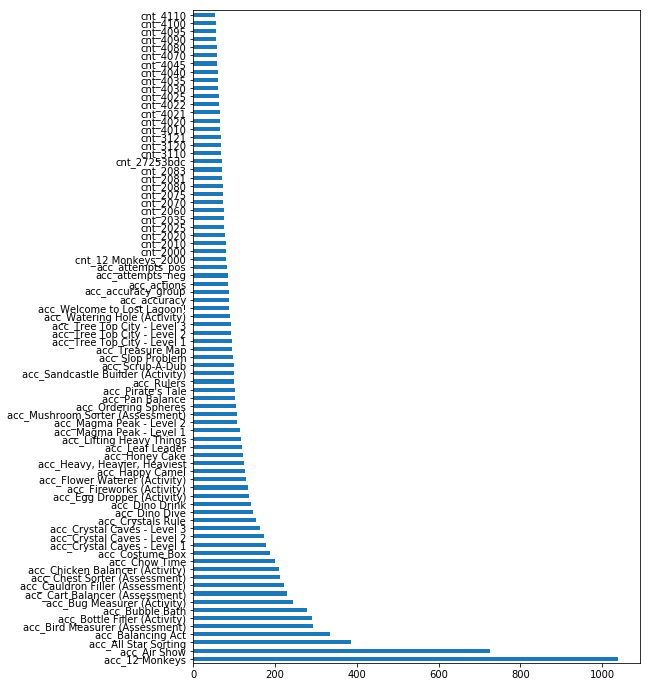

In [32]:
plot_feat_imp(result.fi.head(80), figsize=(8, 12))

In [67]:
features = result.fi[result.fi > 2.].index.tolist()

In [71]:
bundle.save(features, 'features')

'/tmp/bowl2019/features.joblib'

In [68]:
from IPython.display import display
algo = 'lightgbm'
version = '008'

if U.on_kaggle():
    U.log('Inference on Kaggle.')
    predicted = inference(X_tst, features, bounds=bounds, model=algo, version=version)
    U.log('Saving predictions on disk.')
    filename = submit(predicted)
    submit_df = pd.read_csv(filename)
    U.log('First 20 submission rows:')
    display(submit_df.head(20))
    
else:
    U.log('Training with sub-optimal rounding.')
    reg_metric = RegressionCappa([-np.inf, 1., 2., 3., +np.inf])
    result = train(X_trn, features, reg_metric, algo=algo)
    
    U.log('Using predictions to find optimal rounding boundaries.')
    opt_bounds = optimize_rounding_bounds(result.oof, X_trn['accuracy_group'])
    U.log(f'Optimal values: {opt_bounds}')
    
    U.log('Using optimal boundaries to train a new ensemble of models.')
    reg_metric = RegressionCappa(opt_bounds)
    result = train(X_trn, features, reg_metric, algo=algo)
    
    U.log('Saving the final results.')
    bundle.save(result.models, f'models_{algo}_{version}')
    bundle.save(opt_bounds, 'bounds')

Training with sub-optimal rounding.
Running k-fold 1 of 5
Training until validation scores don't improve for 100 rounds.
[100]	trn's rmse: 1.03775	trn's cappa: 0.396122	val's rmse: 1.05408	val's cappa: 0.368843
[200]	trn's rmse: 0.970746	trn's cappa: 0.48435	val's rmse: 1.00485	val's cappa: 0.447481
[300]	trn's rmse: 0.936423	trn's cappa: 0.511385	val's rmse: 0.989294	val's cappa: 0.463738
[400]	trn's rmse: 0.911998	trn's cappa: 0.526337	val's rmse: 0.982301	val's cappa: 0.472153
[500]	trn's rmse: 0.892964	trn's cappa: 0.540157	val's rmse: 0.978787	val's cappa: 0.475863
[600]	trn's rmse: 0.876004	trn's cappa: 0.551911	val's rmse: 0.977064	val's cappa: 0.479959
[700]	trn's rmse: 0.860924	trn's cappa: 0.560728	val's rmse: 0.976534	val's cappa: 0.478638
Early stopping, best iteration is:
[647]	trn's rmse: 0.868572	trn's cappa: 0.557171	val's rmse: 0.976513	val's cappa: 0.480736
Running k-fold 2 of 5
Training until validation scores don't improve for 100 rounds.
[100]	trn's rmse: 1.0376	tr

In [72]:
if not U.on_kaggle():
    features = bundle.features()
    bounds = bundle.bounds()
    filename = submit(inference(X_tst, features, bounds, model=algo, version=version))
    assert os.path.exists(filename)
    assert pd.read_csv(filename).shape[0] == 1000
    bundle.package(folder='/home/ck/data/bowl2019/external/')

Running inference on dataset of shape: 465
Loading external models: lightgbm v008.
Running models on test data...
Averaging ensemble predictions.
Rounding predictions using optimal bounds.
Converting predictions into submission file.
Running locally.
(1000, 2) Packaging training results into dataset.
/tmp/bowl2019/meta.joblib --> /home/ck/data/bowl2019/external/meta.joblib
/tmp/bowl2019/bounds.joblib --> /home/ck/data/bowl2019/external/bounds.joblib
/tmp/bowl2019/features.joblib --> /home/ck/data/bowl2019/external/features.joblib
/tmp/bowl2019/encoders.joblib --> /home/ck/data/bowl2019/external/encoders.joblib
/tmp/bowl2019/models_lightgbm_008.joblib --> /home/ck/data/bowl2019/external/models_lightgbm_008.joblib
Packaging helper scripts into dataset.
../style.py --> /home/ck/data/bowl2019/external/style.py
../basedir.py --> /home/ck/data/bowl2019/external/basedir.py
../dataset.py --> /home/ck/data/bowl2019/external/dataset.py
../extract_features.py --> /home/ck/data/bowl2019/external/e

In [82]:
# inference(X_tst, features, bounds=bounds, model=algo, version=version)